# Punto 1  
## a. El diámetro de la red.  
Primero creamos nuestro grafo a partir del set de datos World.csv que nos proveen.

In [25]:
from collections import deque
import csv

graph = {}

with open('World.csv', 'r') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    next(csv_reader) #remove header
    for row in csv_reader:
        if row[0] not in graph:
            graph[row[0]] = set()
        graph[row[0]].add(row[1])


De esta forma graph será un diccionario que representa nuestra red, donde cada clave será el nombre de un nodo y su valor la lista de vecinos de dicho nodo.  
  
El diámetro está definido como la mayor de las distancias entre todos los pares de vértices del grafo. Para hallarlo aplicamos el algoritmo BFS para obtener el camino mínimo para cada par de nodos. El diámetro será el largo máximo de todos los caminos mínimos.

In [26]:
def graph_diameter(graph):
    max_diameter = 0
    for node in graph:
        distances = bfs(graph, node)
        max_distance = max(distances.values())
        max_diameter = max(max_diameter, max_distance)
    return max_diameter


def bfs(graph, start):
    visited = set()
    queue = deque([(start, 0)])
    distances = {start: 0}

    while queue:
        node, dist = queue.popleft()

        if node not in visited:
            visited.add(node)
            for neighbor in graph.get(node, []):
                if neighbor not in distances:
                    distances[neighbor] = dist + 1
                    queue.append((neighbor, dist + 1))

    return distances

print(f'Network diameter: {graph_diameter(graph)}')

Network diameter: 7


## b. El grado promedio de la red.
Para el resto del análisis puede resultar menos ágil trabajar con el grafo representado como un diccionario y desarrollar los algoritmos por nosotros mismos. Por lo que optamos por utilizar la biblioteca NetworkX de Python, que proporciona funcionalidades integradas para trabajar con redes.  
  
Representamos la red como un grafo de la siguiente manera:

In [27]:
import networkx as nx

nx_graph = nx.DiGraph()

for node, neighbors in graph.items():
    nx_graph.add_node(node)
    for neighbor in neighbors:
        nx_graph.add_edge(node, neighbor)

Utilizamos la función degree para calcular el grado de cada nodo de la red.  

In [28]:
import math

average_degree = sum(dict(nx_graph.degree()).values()) / len(nx_graph)
print(f'Average degree: {math.ceil(average_degree)}')

Average degree: 25


## c. El coeficiente de clustering promedio de la red.
Dicho coeficiente se obtiene como la cantidad de triángulos dividida la cantidad de triángulos que se podrían generar.

In [34]:
clustering_coefficient = nx.average_clustering(nx_graph)
print(f'Clustering coefficient: {round(clustering_coefficient, 2)}')

Clustering coefficient: 0.33


# Punto 2
## a. Indicar si existe algún tipo de Homofilia y qué tipo de homofilia es. Si no hay homofilia por ningún criterio, explicar. Justificar detalladamente.

## b. Obtener una visualización de las comunidades presentes en dicha red (indicando el algoritmo utilizado).

## c. Considerando lo mencionado en el punto (2.a), ¿corresponde lo encontrado por el algoritmo de detección de comunidades en relación a lo indicado en dicho punto? ¿Se verifica que efectivamente hay homofilia, o no, según hayas indicado? ¿como contrastan este resultado con lo indicado (y calculado) anteriormente?

# Punto 3
## a. Determinar un tipo de centralidad que podría ser útil calcular para esta red, justificando.

Con la centralidad buscamos definir cuales son los nodos más importantes o influyentes. Depende del contexto de la red cuál métrica tendrá más sentido aplicar.  
Para el set de datos dado consideramos útil calcular Betweenness Centrality, ya que la misma nos brinda la cantidad de veces que un vértice aparece como intermediario en algún camino mínimo. Como nuestro problema se trata de vuelos entre ciudades, visualizar dichos nodos nos permitirá ver qué lugares pueden servir como puntos de escalas. Es decir, aquellos lugares desde donde se puede llegar a más destinos o a los que se puede acceder desde múltiples destinos.  
Esta centralidad nos permite ver puntos estratégicos en la red de vuelos, los cuales pueden ser importantes para conexiones de vuelos, planificación de rutas. También podría ayudar a las aerolíneas a optimizar los servicios de vuelos. Se podría detectar en qué ciudades habrá mayor congestión por ser más probable recibir un mayor número de pasajeros al haber más conexiones.  
En resumen podemos ver la importancia de las ciudades en nuestra red de vuelos.  
  
## b. Realizar una representación gráfica de dicha red, considerando la centralidad de los distintos países dada por la métrica del punto a (tamaño de los nodos proporcional a dicha métrica).

In [30]:
betweenness_centrality = nx.betweenness_centrality(nx_graph)

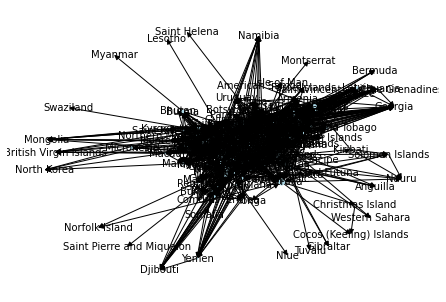

In [31]:
import matplotlib.pyplot as plt

node_sizes = [2000 * betweenness_centrality[node] for node in nx_graph.nodes]
pos = nx.spring_layout(nx_graph, k=0.2, iterations=50)  # Posicionamiento de los nodos
nx.draw(nx_graph, pos, with_labels=True, node_size=node_sizes, node_color='lightblue', font_size=10)
plt.show()

Si bien se puede jugar con los parámetros k e iteration del spring layout, optamos por utilizar la herramienta Gephi que resulta más amigable a la hora de visualizar nuestra red. Además nos provee de diferentes cálculos de centralidad.  
La representación gráfica se muestra en el informe.

# Punto 7
## Determinar los puentes (globales o locales) en dicha red.
Para obtener los puentes necesitamos transformar nuestro grafo en un grafo no dirigido para poder utilizar la función nx.bridges. Luego para cada puente encontrado se procede a eliminar dicha arista del grafo y se verifica si se divide la red en componentes disjuntas.

In [33]:
undirected_graph = nx.Graph(nx_graph)

# Encontrar los puentes en el grafo no dirigido
bridges = list(nx.bridges(undirected_graph))

print("Puentes en la red:")
for bridge in bridges:
    undirected_graph_copy = undirected_graph.copy()
    undirected_graph_copy.remove_edge(*bridge)
    
    # Verificar si la eliminación de la arista dividió la red en componentes disjuntas
    components = list(nx.connected_components(undirected_graph_copy))
    if len(components) == 1:
        print(f"Puente global: {bridge}")
    else:
        print(f"Puente local: {bridge}")

Puentes en la red:
Puente local: ('Fiji', 'Tuvalu')
Puente local: ('Canada', 'Saint Pierre and Miquelon')
Puente local: ('United States', 'American Samoa')
Puente local: ('United Kingdom', 'Saint Helena')
Puente local: ('New Zealand', 'Niue')
Puente local: ('Antigua and Barbuda', 'Montserrat')
Puente local: ('South Africa', 'Swaziland')
Puente local: ('South Africa', 'Lesotho')
Puente local: ('Burma', 'Myanmar')
